In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_sauvola, threshold_niblack
from scipy.ndimage import distance_transform_edt
import os


In [30]:
base_path = "/kaggle/input/retinal-vessel-segmentation/DRIVE"

images_path = os.path.join(base_path, "training", "images")
masks_path  = os.path.join(base_path, "training", "1st_manual")

image_list = sorted(os.listdir(images_path))
mask_list  = sorted(os.listdir(masks_path))

print("Total Images:", len(image_list))


Total Images: 20


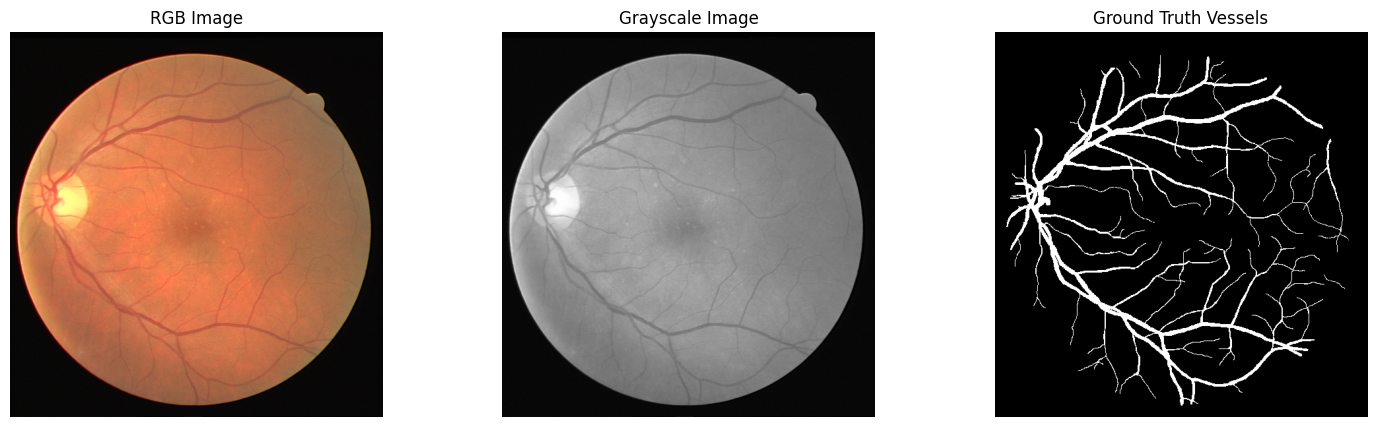

In [31]:
idx = 0

img_bgr = cv2.imread(os.path.join(images_path, image_list[idx]))
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

mask_img = cv2.imread(os.path.join(masks_path, mask_list[idx]), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(18,5))
plt.subplot(1,3,1); plt.imshow(img_rgb); plt.title("RGB Image"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(img_gray, cmap='gray'); plt.title("Grayscale Image"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(mask_img, cmap='gray'); plt.title("Ground Truth Vessels"); plt.axis("off")
plt.show()


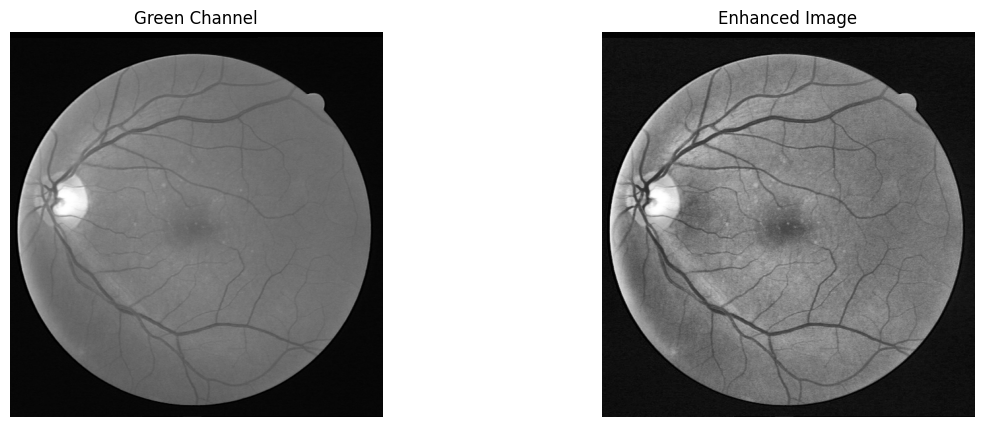

In [32]:
green = img_rgb[:, :, 1]

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
green_enhanced = clahe.apply(green)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1); plt.imshow(green, cmap='gray'); plt.title("Green Channel"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(green_enhanced, cmap='gray'); plt.title("Enhanced Image"); plt.axis("off")
plt.show()


In [33]:
def extract_thin_vessels(gt, thickness=2):
    dist = distance_transform_edt(gt == 0)
    thin = ((gt > 0) & (dist <= thickness)).astype(np.uint8)
    return thin

gt = (mask_img > 0).astype(np.uint8)
thin_gt = extract_thin_vessels(gt)



In [34]:
def sensitivity(pred, gt):
    pred = pred.astype(bool)
    gt   = gt.astype(bool)

    tp = np.logical_and(pred, gt).sum()
    fn = np.logical_and(~pred, gt).sum()

    return tp / (tp + fn + 1e-7)


In [35]:
niblack_windows = [15, 25, 35]
niblack_ks = [-0.3, -0.2, -0.1]

best_niblack_score = 0
best_niblack_params = None
best_niblack_mask = None

thin_gt = extract_thin_vessels(gt)

for w in niblack_windows:
    for k in niblack_ks:
        
        th = threshold_niblack(green_enhanced, window_size=w, k=k)
        mask = (green_enhanced < th).astype(np.uint8)

        score = sensitivity(mask, thin_gt)

        if score > best_niblack_score:
            best_niblack_score = score
            best_niblack_params = (w, k)
            best_niblack_mask = mask

print("Best Niblack Parameters:", best_niblack_params)
print("Best Niblack Thin-Vessel Sensitivity:", best_niblack_score)



Best Niblack Parameters: (25, -0.3)
Best Niblack Thin-Vessel Sensitivity: 0.9355584394479051


In [36]:
sauvola_windows = [15, 25, 35]
sauvola_ks = [0.3, 0.2, 0.1]

best_sauvola_score = 0
best_sauvola_params = None
best_sauvola_mask = None

thin_gt = extract_thin_vessels(gt)

for w in sauvola_windows:
    for k in sauvola_ks:
        
        th = threshold_sauvola(green_enhanced, window_size=w, k=k, r=128)
        mask = (green_enhanced < th).astype(np.uint8)

        score = sensitivity(mask, thin_gt)

        if score > best_sauvola_score:
            best_sauvola_score = score
            best_sauvola_params = (w, k)
            best_sauvola_mask = mask

print("Best Sauvola Parameters:", best_sauvola_params)
print("Best Sauvola Thin-Vessel Sensitivity:", best_sauvola_score)


Best Sauvola Parameters: (35, 0.1)
Best Sauvola Thin-Vessel Sensitivity: 0.7561440506093108


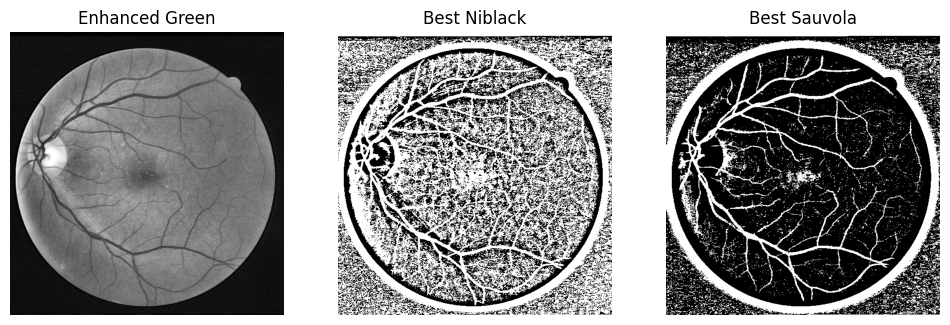

In [37]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(green_enhanced, cmap="gray")
plt.title("Enhanced Green")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(best_niblack_mask, cmap="gray")
plt.title("Best Niblack")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(best_sauvola_mask, cmap="gray")
plt.title("Best Sauvola")
plt.axis("off")

plt.show()
